# Baseline Models for Temporal Node Classification

This notebook trains **two baseline models** to establish performance benchmarks:
1. **Logistic Regression** (no graph structure, features only)
2. **Static GCN** (single graph snapshot with message passing)

## Approach:
- For each node, classify it at timestep `t = first_appearance + K`
- LR uses only node features (no graph)
- GCN uses graph snapshot at that timestep
- Compare performance across different observation windows K

## Purpose:
- **LR baseline**: Establish if node features alone are predictive
- **GCN baseline**: Test if graph structure adds value over features alone
- These baselines will be compared against temporal GCNs (EvolveGCN)

In [1]:
import sys
from pathlib import Path
import time

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_data_for_observation_window
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
print('✅ Imports successful!')

ImportError: cannot import name 'prepare_data_for_observation_window' from 'code_lib.temporal_node_classification_builder' (/Users/franciszeklatala/Delft/ML for Graph Data/graph_ml/code_lib/temporal_node_classification_builder.py)

## 1. Configuration

In [14]:
# Experiment configuration
CONFIG = {
    'data_dir': '../elliptic_dataset',
    
    # Temporal split
    'train_timesteps': (5, 29),
    'val_timesteps': (30, 33),
    'test_timesteps': (34, 42),
    
    # observation windows to test
    'observation_windows': [0, 3, 5, 7],
    
    # Model hyperparameters
    'hidden_dim': 64,
    'dropout': 0.5,
    'learning_rate': 0.01,
    'weight_decay': 5e-4,
    'epochs': 200,
    'patience': 20,  # Early stopping
    
    # Training
    'device': 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'),
    'seed': 42
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  data_dir: ../elliptic_dataset
  train_timesteps: (5, 29)
  val_timesteps: (30, 33)
  test_timesteps: (34, 42)
  observation_windows: [0, 3, 5, 7]
  hidden_dim: 64
  dropout: 0.5
  learning_rate: 0.01
  weight_decay: 0.0005
  epochs: 200
  patience: 20
  device: mps
  seed: 42


In [7]:
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['seed'])

## 2. Load Data and Create Graph Builder

In [5]:
print("Loading Elliptic Bitcoin dataset...")
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

print(f"\nNodes: {nodes_df.shape}")
print(f"Edges: {edges_df.shape}")
print(f"Unique addresses: {nodes_df['address'].nunique():,}")

Loading Elliptic Bitcoin dataset...

Nodes: (920691, 119)
Edges: (2868964, 187)
Unique addresses: 822,942


In [8]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    include_class_as_feature=False,  # Don't leak labels
    add_temporal_features=True,      # Add node age
    cache_dir='../graph_cache',      # Cache graphs for faster loading
    use_cache=True,                  # Enable caching (default)
    verbose=True
)

print("\n💡 Graph caching is enabled!")
print("   First run: Graphs will be built and cached")
print("   Subsequent runs: Graphs will load from cache (50-100x faster!)")
print("   To clear cache: builder.clear_cache()")

  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (116): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_median_fees', 'in_total_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False

💡 Graph caching is enabled!
   First run: Graphs will be built and cached
   Subsequent runs: Graphs will load from cache (50-100x faster!)
   To clear cache: builder.clear_cache()


### 📦 Graph Caching

The graph builder now includes automatic caching to speed up repeated runs:

- **First run**: Graphs are built from scratch and saved to `../graph_cache/`
- **Subsequent runs**: Graphs are loaded from cache (~50-100x faster!)
- **Clear cache**: Run `builder.clear_cache()` if you change the data or configuration

This is especially useful for:
- 🔄 Running the notebook multiple times during development
- 🎯 Testing different model configurations on the same graphs
- 🐛 Debugging without waiting for graph construction

## 3. Create Temporal Data Split

In [9]:
split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True  # Only use labeled nodes
)

train_nodes = split['train']
val_nodes = split['val']
test_nodes = split['test']

print(f"\nSplit summary:")
print(f"  Train: {len(train_nodes)} nodes")
print(f"  Val:   {len(val_nodes)} nodes")
print(f"  Test:  {len(test_nodes)} nodes")


Temporal Split Summary:
  Train: timesteps 5-29, 109133 nodes
    Illicit: 7237, Licit: 101896
Training illicit ratio: 0.06631358067678887
  Val:   timesteps 30-33, 16718 nodes
    Illicit: 1305, Licit: 15413
Validation illicit ratio: 0.07805957650436655
  Test:  timesteps 34-42, 50876 nodes
    Illicit: 3218, Licit: 47658
Test illicit ratio: 0.06325182797389732

Split summary:
  Train: 109133 nodes
  Val:   16718 nodes
  Test:  50876 nodes


## 4. Define Static GCN Model

In [10]:
class StaticGCN(nn.Module):
    """
    Static GCN for node classification.
    
    Two-layer GCN that operates on a single graph snapshot.
    No temporal modeling - serves as baseline.
    """
    
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(StaticGCN, self).__init__()
        
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        return x  # Return logits
    
    def predict(self, x, edge_index):
        """Get predictions (class probabilities)."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x, edge_index)
            return F.softmax(logits, dim=1)

print("✅ StaticGCN model defined")

✅ StaticGCN model defined


## 5. Training and Evaluation Functions

In [11]:
def train_epoch(model, data, train_mask, optimizer, criterion, device):
    """
    Train for one epoch on a single graph.
    """
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    logits = model(data.x, data.edge_index)
    
    # Compute loss only on training nodes
    loss = criterion(logits[train_mask], data.y[train_mask])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Compute accuracy
    with torch.no_grad():
        pred = logits[train_mask].argmax(dim=1)
        acc = (pred == data.y[train_mask]).float().mean()
    
    return loss.item(), acc.item()


def evaluate(model, data, eval_mask, device):
    """
    Evaluate model on a single graph.
    """
    model.eval()
    
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        
        # Predictions
        pred = logits[eval_mask].argmax(dim=1)
        true = data.y[eval_mask]
        
        # Metrics
        acc = (pred == true).float().mean().item()
        
        # Convert to CPU numpy for sklearn metrics
        pred_np = pred.cpu().numpy()
        true_np = true.cpu().numpy()
        
        # Precision, recall, F1
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_np, pred_np, average='binary', pos_label=1, zero_division=0
        )
        
        # ROC AUC
        probs = F.softmax(logits[eval_mask], dim=1)[:, 1].cpu().numpy()
        try:
            auc = roc_auc_score(true_np, probs)
        except:
            auc = 0.5
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

print("✅ Training functions defined")

✅ Training functions defined


## 7C. Train Static GCN for Each Observation Window

In [15]:
# Store results for all observation windows
results = {}
models = {}

device = torch.device(CONFIG['device'])
print(f"Using device: {device}")

Using device: mps


## 🔍 DIAGNOSTIC: Why is Performance So Bad?

In [16]:
# Let's diagnose the issues
print("="*70)
print("DIAGNOSTIC ANALYSIS: Why GCN Performs Poorly")
print("="*70)

# Check K=0 graph
K = 0
data = prepare_data_for_observation_window(
    K, builder, train_nodes, val_nodes, test_nodes, device
)

print(f"\n1. FEATURE STATISTICS (K={K}):")
print(f"   Feature shape: {data.x.shape}")
print(f"   Feature mean: {data.x.mean(dim=0)[:10]}")  # First 10 features
print(f"   Feature std: {data.x.std(dim=0)[:10]}")
print(f"   Feature min: {data.x.min(dim=0)[0][:10]}")
print(f"   Feature max: {data.x.max(dim=0)[0][:10]}")

# Check for NaN/Inf
has_nan = torch.isnan(data.x).any()
has_inf = torch.isinf(data.x).any()
print(f"\n   Has NaN: {has_nan}, Has Inf: {has_inf}")

# Check feature variance
feature_variance = data.x.var(dim=0)
zero_variance = (feature_variance < 1e-6).sum().item()
print(f"   Features with near-zero variance: {zero_variance} / {data.x.shape[1]}")

print(f"\n2. GRAPH STRUCTURE:")
print(f"   Nodes: {data.num_nodes:,}")
print(f"   Edges: {data.edge_index.shape[1]:,}")
print(f"   Avg degree: {data.edge_index.shape[1] / data.num_nodes:.2f}")

# Check graph connectivity
unique_src = data.edge_index[0].unique().shape[0]
unique_dst = data.edge_index[1].unique().shape[0]
connected_nodes = len(set(data.edge_index[0].tolist()) | set(data.edge_index[1].tolist()))
isolated_nodes = data.num_nodes - connected_nodes
print(f"   Connected nodes: {connected_nodes:,} ({100*connected_nodes/data.num_nodes:.1f}%)")
print(f"   Isolated nodes: {isolated_nodes:,} ({100*isolated_nodes/data.num_nodes:.1f}%)")

print(f"\n3. CLASS DISTRIBUTION IN GRAPH:")
all_labels = data.y.cpu().numpy()
licit_all = (all_labels == 0).sum()
illicit_all = (all_labels == 1).sum()
unknown_all = (all_labels == 2).sum()
print(f"   All nodes: {len(all_labels):,}")
print(f"     Licit (0):   {licit_all:,} ({100*licit_all/len(all_labels):.1f}%)")
print(f"     Illicit (1): {illicit_all:,} ({100*illicit_all/len(all_labels):.1f}%)")
print(f"     Unknown (2): {unknown_all:,} ({100*unknown_all/len(all_labels):.1f}%)")

print(f"\n4. TRAIN/VAL/TEST DISTRIBUTION:")
train_labels = data.y[data.train_mask].cpu().numpy()
val_labels = data.y[data.val_mask].cpu().numpy()
test_labels = data.y[data.test_mask].cpu().numpy()

for split_name, labels in [("Train", train_labels), ("Val", val_labels), ("Test", test_labels)]:
    licit = (labels == 0).sum()
    illicit = (labels == 1).sum()
    print(f"   {split_name}: {len(labels):,} nodes")
    print(f"     Licit:   {licit:,} ({100*licit/len(labels):.1f}%)")
    print(f"     Illicit: {illicit:,} ({100*illicit/len(labels):.1f}%)")

print(f"\n5. ISOLATED NODES IN TRAINING:")
train_node_indices = data.train_mask.nonzero(as_tuple=True)[0]
connected_node_set = set(data.edge_index[0].tolist()) | set(data.edge_index[1].tolist())
isolated_train = 0
for idx in train_node_indices.tolist():
    if idx not in connected_node_set:
        isolated_train += 1
print(f"   Isolated training nodes: {isolated_train:,} / {len(train_node_indices):,} ({100*isolated_train/len(train_node_indices):.1f}%)")

print(f"\n6. POTENTIAL ISSUES:")
issues = []
if zero_variance > data.x.shape[1] * 0.5:
    issues.append("⚠️  More than 50% of features have near-zero variance")
if isolated_nodes > data.num_nodes * 0.1:
    issues.append(f"⚠️  {isolated_nodes/data.num_nodes*100:.1f}% of nodes are isolated (no edges)")
if isolated_train > len(train_node_indices) * 0.05:
    issues.append(f"⚠️  {isolated_train/len(train_node_indices)*100:.1f}% of training nodes are isolated")
if illicit_all < licit_all * 0.1:
    issues.append(f"⚠️  Severe class imbalance: {licit_all/illicit_all:.1f}:1 (licit:illicit)")
if data.x.std(dim=0).mean() < 0.1:
    issues.append("⚠️  Features might need normalization (low variance)")

if issues:
    print("   " + "\n   ".join(issues))
else:
    print("   No obvious structural issues detected")

print("="*70)

DIAGNOSTIC ANALYSIS: Why GCN Performs Poorly

Preparing data for K=0...
  Building graph at t=42...
  💾 Cached graph to ../graph_cache/graph_t42_metaTrue_classFalse_tempTrue_weightsFalse.pt
  Graph: 697242 nodes, 2215839 edges
  Train nodes: 109133
  Val nodes:   16718
  Test nodes:  50876

1. FEATURE STATISTICS (K=0):
   Feature shape: torch.Size([697242, 117])
   Feature mean: tensor([1.0365e+00, 3.5490e-02, 5.8560e-03, 5.8382e-03, 1.2896e+02, 5.3979e+01,
        5.3231e+01, 3.5490e-02, 5.8560e-03, 5.8382e-03], device='mps:0')
   Feature std: tensor([4.2727e+00, 7.7278e-01, 1.9980e-02, 1.9983e-02, 1.6109e+03, 2.2103e+02,
        2.2058e+02, 7.7278e-01, 1.9980e-02, 1.9983e-02], device='mps:0')
   Feature min: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0')
   Feature max: tensor([1.4710e+03, 2.5957e+02, 2.7228e-01, 2.7228e-01, 6.2429e+05, 1.1392e+04,
        1.1392e+04, 2.5957e+02, 2.7228e-01, 2.7228e-01], device='mps:0')

   Has NaN: False, Has Inf: False
   Features

## 7B. Logistic Regression Baseline (No Graph)

Before training GCN, let's establish a baseline using **only node features** (no graph structure).
This will tell us if the graph actually provides useful signal for classification.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

print("✅ Sklearn imports for baseline")

✅ Sklearn imports for baseline


In [18]:
# Store logistic regression results
lr_results = {}

print("="*70)
print("LOGISTIC REGRESSION BASELINE (NO GRAPH)")
print("="*70)
print("\nThis baseline uses ONLY node features, ignoring all graph structure.")
print("If GCN doesn't beat this, the graph isn't helping!\n")

for K in CONFIG['observation_windows']:
    print(f"\n{'='*70}")
    print(f"LOGISTIC REGRESSION WITH K={K}")
    print('='*70)
    
    # Prepare data (same as GCN)
    data = prepare_data_for_observation_window(
        K, builder, train_nodes, val_nodes, test_nodes, device
    )
    
    # Extract features and labels as numpy arrays
    X_all = data.x.cpu().numpy()
    y_all = data.y.cpu().numpy()
    
    train_mask = data.train_mask.cpu().numpy()
    val_mask = data.val_mask.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()
    
    X_train = X_all[train_mask]
    y_train = y_all[train_mask]
    X_val = X_all[val_mask]
    y_val = y_all[val_mask]
    X_test = X_all[test_mask]
    y_test = y_all[test_mask]
    
    print(f"\nData shapes:")
    print(f"  Train: {X_train.shape}, {np.bincount(y_train)}")
    print(f"  Val:   {X_val.shape}, {np.bincount(y_val)}")
    print(f"  Test:  {X_test.shape}, {np.bincount(y_test)}")
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train logistic regression with class weighting
    # Calculate class weights (same as GCN)
    class_counts_np = np.bincount(y_train)
    class_weight_dict = {
        0: len(y_train) / (2 * class_counts_np[0]),  # Licit
        1: len(y_train) / (2 * class_counts_np[1])   # Illicit
    }
    
    print(f"\nClass weights: {class_weight_dict}")
    
    # Train with regularization
    lr_model = LogisticRegression(
        class_weight=class_weight_dict,
        max_iter=1000,
        random_state=CONFIG['seed'],
        solver='lbfgs',
        C=1.0  # Regularization strength
    )
    
    print(f"\nTraining Logistic Regression...")
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate on all splits
    def eval_lr(X, y, split_name):
        y_pred = lr_model.predict(X)
        y_proba = lr_model.predict_proba(X)[:, 1]  # Probability of illicit
        
        acc = accuracy_score(y, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y, y_pred, average='binary', pos_label=1, zero_division=0
        )
        
        try:
            auc = roc_auc_score(y, y_proba)
        except:
            auc = 0.5
        
        print(f"\n{split_name}:")
        print(f"  Acc={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
        print(f"  F1={f1:.4f}, AUC={auc:.4f}")
        
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
    
    train_metrics = eval_lr(X_train_scaled, y_train, "Train")
    val_metrics = eval_lr(X_val_scaled, y_val, "Val")
    test_metrics = eval_lr(X_test_scaled, y_test, "Test")
    
    # Store results
    lr_results[K] = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'model': lr_model,
        'scaler': scaler
    }

print("\n" + "="*70)
print("✅ Logistic Regression baseline complete!")
print("="*70)

LOGISTIC REGRESSION BASELINE (NO GRAPH)

This baseline uses ONLY node features, ignoring all graph structure.
If GCN doesn't beat this, the graph isn't helping!


LOGISTIC REGRESSION WITH K=0

Preparing data for K=0...
  Building graph at t=42...
  ⚠️  Failed to load cached graph: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `tor

In [19]:
# Create comparison table for LR
lr_comparison_data = []

for K in CONFIG['observation_windows']:
    test_metrics = lr_results[K]['test']
    lr_comparison_data.append({
        'K': K,
        'Accuracy': test_metrics['accuracy'],
        'Precision': test_metrics['precision'],
        'Recall': test_metrics['recall'],
        'F1': test_metrics['f1'],
        'AUC': test_metrics['auc']
    })

lr_comparison_df = pd.DataFrame(lr_comparison_data)

print("\n" + "="*70)
print("LOGISTIC REGRESSION TEST SET PERFORMANCE")
print("="*70)
print(lr_comparison_df.to_string(index=False))
print("="*70)


LOGISTIC REGRESSION TEST SET PERFORMANCE
 K  Accuracy  Precision   Recall       F1      AUC
 0  0.360366   0.087776 0.970168 0.160986 0.892894
 3  0.345153   0.085861 0.969546 0.157751 0.891008
 5  0.351954   0.086686 0.969546 0.159143 0.893356
 7  0.344720   0.085809 0.969546 0.157663 0.891424



Preparing data for K=0...
  Building graph at t=42...
  ⚠️  Failed to load cached graph: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` or the `torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr])` context manager to allowlist th

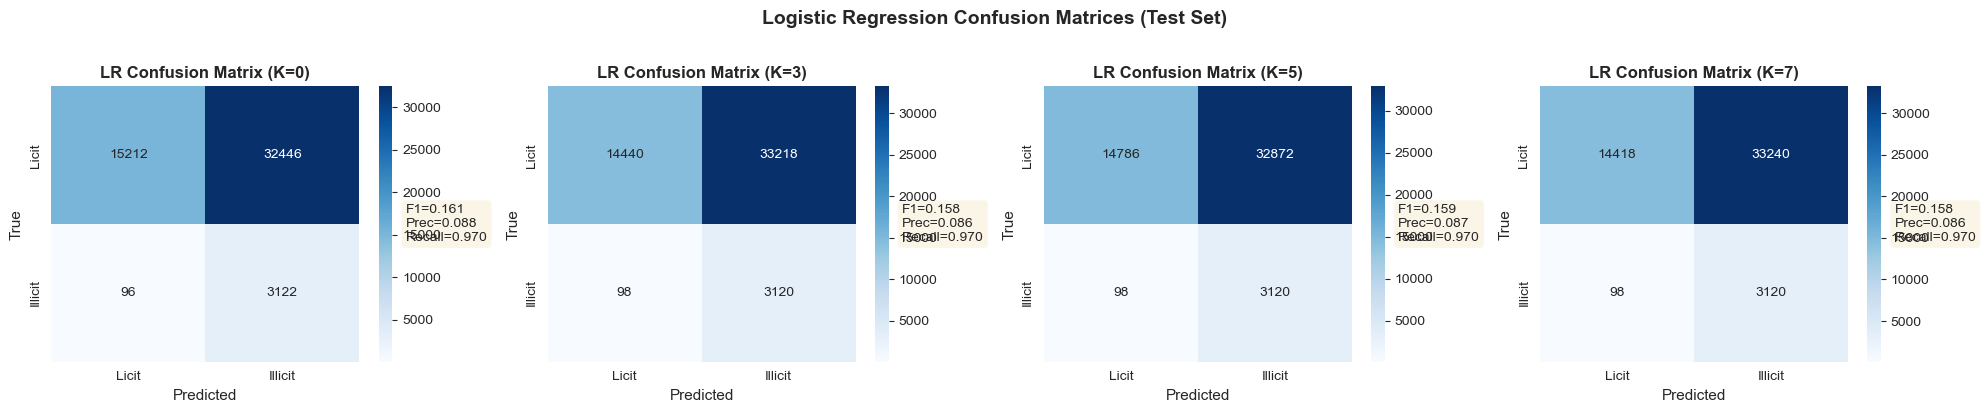

In [20]:
# Confusion Matrices for Logistic Regression
fig, axes = plt.subplots(1, len(CONFIG['observation_windows']), 
                         figsize=(5*len(CONFIG['observation_windows']), 4))

if len(CONFIG['observation_windows']) == 1:
    axes = [axes]

for idx, K in enumerate(CONFIG['observation_windows']):
    ax = axes[idx]
    
    # Get data for this K
    data = prepare_data_for_observation_window(
        K, builder, train_nodes, val_nodes, test_nodes, device
    )
    
    X_test = data.x[data.test_mask].cpu().numpy()
    y_test = data.y[data.test_mask].cpu().numpy()
    
    # Get model and scaler
    lr_model = lr_results[K]['model']
    scaler = lr_results[K]['scaler']
    
    # Scale features and get predictions
    X_test_scaled = scaler.transform(X_test)
    y_pred = lr_model.predict(X_test_scaled)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Licit', 'Illicit'],
                yticklabels=['Licit', 'Illicit'])
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('True', fontsize=11)
    ax.set_title(f'LR Confusion Matrix (K={K})', fontsize=12, fontweight='bold')
    
    # Add metrics as text
    f1 = lr_results[K]['test']['f1']
    precision = lr_results[K]['test']['precision']
    recall = lr_results[K]['test']['recall']
    
    metrics_text = f'F1={f1:.3f}\nPrec={precision:.3f}\nRecall={recall:.3f}'
    ax.text(1.15, 0.5, metrics_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Logistic Regression Confusion Matrices (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


Preparing data for K=0...
  Building graph at t=42...
  ⚠️  Failed to load cached graph: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` or the `torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr])` context manager to allowlist th

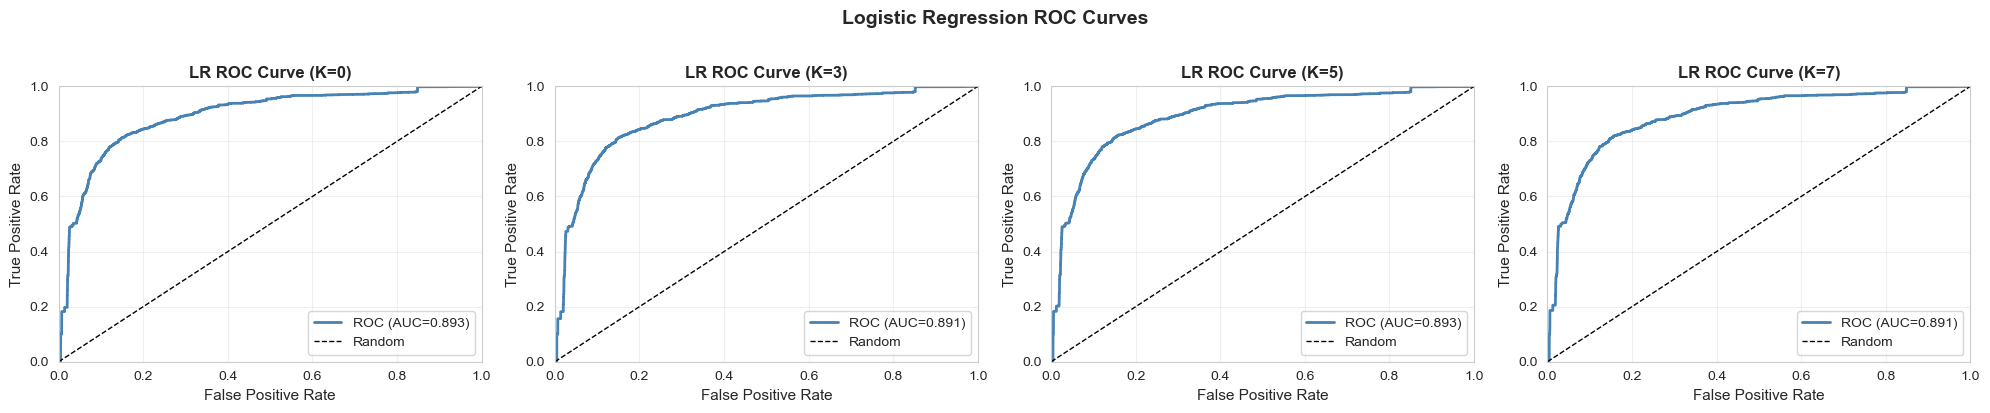

In [21]:
# ROC Curves for Logistic Regression
from sklearn.metrics import roc_curve

fig, axes = plt.subplots(1, len(CONFIG['observation_windows']), 
                         figsize=(5*len(CONFIG['observation_windows']), 4))

if len(CONFIG['observation_windows']) == 1:
    axes = [axes]

for idx, K in enumerate(CONFIG['observation_windows']):
    ax = axes[idx]
    
    # Get data for this K
    data = prepare_data_for_observation_window(
        K, builder, train_nodes, val_nodes, test_nodes, device
    )
    
    X_test = data.x[data.test_mask].cpu().numpy()
    y_test = data.y[data.test_mask].cpu().numpy()
    
    # Get model and scaler
    lr_model = lr_results[K]['model']
    scaler = lr_results[K]['scaler']
    
    # Scale features and get predictions
    X_test_scaled = scaler.transform(X_test)
    y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  # Probability of illicit (class 1)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = lr_results[K]['test']['auc']
    
    # Plot
    ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={auc:.3f})', color='steelblue')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'LR ROC Curve (K={K})', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.suptitle('Logistic Regression ROC Curves', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [15]:
for K in CONFIG['observation_windows']:
    print("\n" + "="*70)
    print(f"TRAINING WITH OBSERVATION WINDOW K={K}")
    print("="*70)
    
    # Prepare data
    data = prepare_data_for_observation_window(
        K, builder, train_nodes, val_nodes, test_nodes, device
    )
    
    # Initialize model
    num_features = data.x.shape[1]
    num_classes = 2  # Binary classification
    
    model = StaticGCN(
        num_features=num_features,
        hidden_dim=CONFIG['hidden_dim'],
        num_classes=num_classes,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Class weights for imbalanced data
    train_labels = data.y[data.train_mask]
    class_counts = torch.bincount(train_labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()  # Normalize
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    print(f"\nModel: {sum(p.numel() for p in model.parameters())} parameters")
    print(f"Class distribution in training set:")
    print(f"  Licit (0):   {class_counts[0]} ({100*class_counts[0]/len(train_labels):.1f}%)")
    print(f"  Illicit (1): {class_counts[1]} ({100*class_counts[1]/len(train_labels):.1f}%)")
    print(f"  Class weights: {class_weights.tolist()}")
    
    # Training loop
    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    print(f"\nTraining for {CONFIG['epochs']} epochs...")
    pbar = tqdm(range(CONFIG['epochs']), desc=f"K={K}")
    
    for epoch in pbar:
        # Train
        train_loss, train_acc = train_epoch(
            model, data, data.train_mask, optimizer, criterion, device
        )
        
        # Validate every 5 epochs
        if (epoch + 1) % 5 == 0:
            val_metrics = evaluate(model, data, data.val_mask, device)
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_metrics['accuracy'])
            history['val_f1'].append(val_metrics['f1'])
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{train_loss:.4f}",
                'val_f1': f"{val_metrics['f1']:.4f}"
            })
            
            # Early stopping
            if val_metrics['f1'] > best_val_f1:
                best_val_f1 = val_metrics['f1']
                patience_counter = 0
                # Save best model
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                
            if patience_counter >= CONFIG['patience']:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation
    print("\n" + "-"*70)
    print("FINAL EVALUATION")
    print("-"*70)
    
    train_metrics = evaluate(model, data, data.train_mask, device)
    val_metrics = evaluate(model, data, data.val_mask, device)
    test_metrics = evaluate(model, data, data.test_mask, device)
    
    print(f"\nTrain: Acc={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
    print(f"Val:   Acc={val_metrics['accuracy']:.4f}, F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
    print(f"Test:  Acc={test_metrics['accuracy']:.4f}, F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")
    
    # Store results
    results[K] = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'history': history
    }
    models[K] = model

print("\n" + "="*70)
print("✅ Training complete for all observation windows!")
print("="*70)


TRAINING WITH OBSERVATION WINDOW K=0

Preparing data for K=0...
  Building graph at t=45...
  Graph: 761396 nodes, 2552766 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Model: 7682 parameters
Class distribution in training set:
  Illicit (0): 139483 (95.6%)
  Licit (1):   6375 (4.4%)
  Class weights: [0.04370689019560814, 0.9562931060791016]

Training for 200 epochs...
  Graph: 761396 nodes, 2552766 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Model: 7682 parameters
Class distribution in training set:
  Illicit (0): 139483 (95.6%)
  Licit (1):   6375 (4.4%)
  Class weights: [0.04370689019560814, 0.9562931060791016]

Training for 200 epochs...


K=0:   0%|          | 0/200 [00:00<?, ?it/s]


Early stopping at epoch 130

----------------------------------------------------------------------
FINAL EVALUATION
----------------------------------------------------------------------

Train: Acc=0.1202, F1=0.0888, AUC=0.7301
Val:   Acc=0.2696, F1=0.2209, AUC=0.5784
Test:  Acc=0.1437, F1=0.0848, AUC=0.4701

TRAINING WITH OBSERVATION WINDOW K=3

Preparing data for K=3...
  Building graph at t=48...

Train: Acc=0.1202, F1=0.0888, AUC=0.7301
Val:   Acc=0.2696, F1=0.2209, AUC=0.5784
Test:  Acc=0.1437, F1=0.0848, AUC=0.4701

TRAINING WITH OBSERVATION WINDOW K=3

Preparing data for K=3...
  Building graph at t=48...
  Graph: 811269 nodes, 2798924 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Model: 7682 parameters
Class distribution in training set:
  Illicit (0): 139483 (95.6%)
  Licit (1):   6375 (4.4%)
  Class weights: [0.04370689019560814, 0.9562931060791016]

Training for 200 epochs...
  Graph: 811269 nodes, 2798924 edges
  Train nodes: 145858
  Val nodes: 

K=3:   0%|          | 0/200 [00:00<?, ?it/s]


Early stopping at epoch 175

----------------------------------------------------------------------
FINAL EVALUATION
----------------------------------------------------------------------

Train: Acc=0.7622, F1=0.1944, AUC=0.7863
Val:   Acc=0.6745, F1=0.2643, AUC=0.6444
Test:  Acc=0.5546, F1=0.0881, AUC=0.5106

TRAINING WITH OBSERVATION WINDOW K=5

Preparing data for K=5...
  Building graph at t=50...

Train: Acc=0.7622, F1=0.1944, AUC=0.7863
Val:   Acc=0.6745, F1=0.2643, AUC=0.6444
Test:  Acc=0.5546, F1=0.0881, AUC=0.5106

TRAINING WITH OBSERVATION WINDOW K=5

Preparing data for K=5...
  Building graph at t=50...
  Graph: 822942 nodes, 2868964 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Model: 7682 parameters
Class distribution in training set:
  Illicit (0): 139483 (95.6%)
  Licit (1):   6375 (4.4%)
  Class weights: [0.04370689019560814, 0.9562931060791016]

Training for 200 epochs...


K=5:   0%|          | 0/200 [00:00<?, ?it/s]


Early stopping at epoch 115

----------------------------------------------------------------------
FINAL EVALUATION
----------------------------------------------------------------------

Train: Acc=0.0923, F1=0.0860, AUC=0.7133
Val:   Acc=0.1675, F1=0.1874, AUC=0.5296
Test:  Acc=0.1430, F1=0.0865, AUC=0.5249

TRAINING WITH OBSERVATION WINDOW K=10

Preparing data for K=10...
  Building graph at t=55...

Train: Acc=0.0923, F1=0.0860, AUC=0.7133
Val:   Acc=0.1675, F1=0.1874, AUC=0.5296
Test:  Acc=0.1430, F1=0.0865, AUC=0.5249

TRAINING WITH OBSERVATION WINDOW K=10

Preparing data for K=10...
  Building graph at t=55...
  Graph: 822942 nodes, 2868964 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Model: 7682 parameters
Class distribution in training set:
  Illicit (0): 139483 (95.6%)
  Licit (1):   6375 (4.4%)
  Class weights: [0.04370689019560814, 0.9562931060791016]

Training for 200 epochs...
  Graph: 822942 nodes, 2868964 edges
  Train nodes: 145858
  Val nod

K=10:   0%|          | 0/200 [00:00<?, ?it/s]


Early stopping at epoch 140

----------------------------------------------------------------------
FINAL EVALUATION
----------------------------------------------------------------------

Train: Acc=0.6850, F1=0.1552, AUC=0.6665
Val:   Acc=0.6104, F1=0.2512, AUC=0.5989
Test:  Acc=0.5972, F1=0.1010, AUC=0.5435

✅ Training complete for all observation windows!

Train: Acc=0.6850, F1=0.1552, AUC=0.6665
Val:   Acc=0.6104, F1=0.2512, AUC=0.5989
Test:  Acc=0.5972, F1=0.1010, AUC=0.5435

✅ Training complete for all observation windows!


## 8. Compare Results Across Observation Windows

In [12]:
# Create comparison table
comparison_data = []

for K in CONFIG['observation_windows']:
    test_metrics = results[K]['test']
    comparison_data.append({
        'K': K,
        'Accuracy': test_metrics['accuracy'],
        'Precision': test_metrics['precision'],
        'Recall': test_metrics['recall'],
        'F1': test_metrics['f1'],
        'AUC': test_metrics['auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("TEST SET PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


TEST SET PERFORMANCE COMPARISON
 K  Accuracy  Precision   Recall       F1      AUC
 0  0.516865   0.040384 0.457362 0.074214 0.521537
 3  0.470899   0.044475 0.561224 0.082419 0.471376
 5  0.247732   0.042827 0.785350 0.081224 0.464812
10  0.501898   0.040108 0.469388 0.073902 0.499099


In [ ]:
# Compare LR vs GCN
print("\n" + "="*70)
print("LOGISTIC REGRESSION vs STATIC GCN COMPARISON")
print("="*70)
print("\nDoes the graph structure help?\n")

comparison_both = []

for K in CONFIG['observation_windows']:
    lr_metrics = lr_results[K]['test']
    gcn_metrics = results[K]['test']
    
    comparison_both.append({
        'K': K,
        'LR_F1': lr_metrics['f1'],
        'GCN_F1': gcn_metrics['f1'],
        'Improvement': gcn_metrics['f1'] - lr_metrics['f1'],
        'LR_AUC': lr_metrics['auc'],
        'GCN_AUC': gcn_metrics['auc'],
        'LR_Precision': lr_metrics['precision'],
        'GCN_Precision': gcn_metrics['precision'],
    })

comparison_both_df = pd.DataFrame(comparison_both)

print(comparison_both_df.to_string(index=False))

print("\n" + "="*70)
if comparison_both_df['Improvement'].mean() > 0.01:
    print("✅ GCN outperforms Logistic Regression - Graph structure helps!")
elif comparison_both_df['Improvement'].mean() < -0.01:
    print("❌ Logistic Regression outperforms GCN - Graph structure hurts!")
else:
    print("⚠️  GCN and LR perform similarly - Graph provides minimal benefit")
print("="*70)

In [ ]:
# Visualize LR vs GCN comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score comparison
ax = axes[0]
x = np.arange(len(CONFIG['observation_windows']))
width = 0.35

lr_f1 = lr_comparison_df['F1'].values
gcn_f1 = comparison_df['F1'].values

ax.bar(x - width/2, lr_f1, width, label='Logistic Regression', alpha=0.8, color='steelblue')
ax.bar(x + width/2, gcn_f1, width, label='Static GCN', alpha=0.8, color='darkgreen')

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score: LR vs GCN', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CONFIG['observation_windows'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (lr_val, gcn_val) in enumerate(zip(lr_f1, gcn_f1)):
    ax.text(i - width/2, lr_val + 0.005, f'{lr_val:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, gcn_val + 0.005, f'{gcn_val:.3f}', ha='center', va='bottom', fontsize=9)

# Precision comparison
ax = axes[1]
lr_prec = lr_comparison_df['Precision'].values
gcn_prec = comparison_df['Precision'].values

ax.bar(x - width/2, lr_prec, width, label='Logistic Regression', alpha=0.8, color='steelblue')
ax.bar(x + width/2, gcn_prec, width, label='Static GCN', alpha=0.8, color='darkgreen')

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision: LR vs GCN', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CONFIG['observation_windows'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# AUC comparison
ax = axes[2]
lr_auc = lr_comparison_df['AUC'].values
gcn_auc = comparison_df['AUC'].values

ax.bar(x - width/2, lr_auc, width, label='Logistic Regression', alpha=0.8, color='steelblue')
ax.bar(x + width/2, gcn_auc, width, label='Static GCN', alpha=0.8, color='darkgreen')

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC: LR vs GCN', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CONFIG['observation_windows'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Logistic Regression (No Graph) vs Static GCN', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

C:\Users\rowde\AppData\Local\Temp\ipykernel_32008\1468774772.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


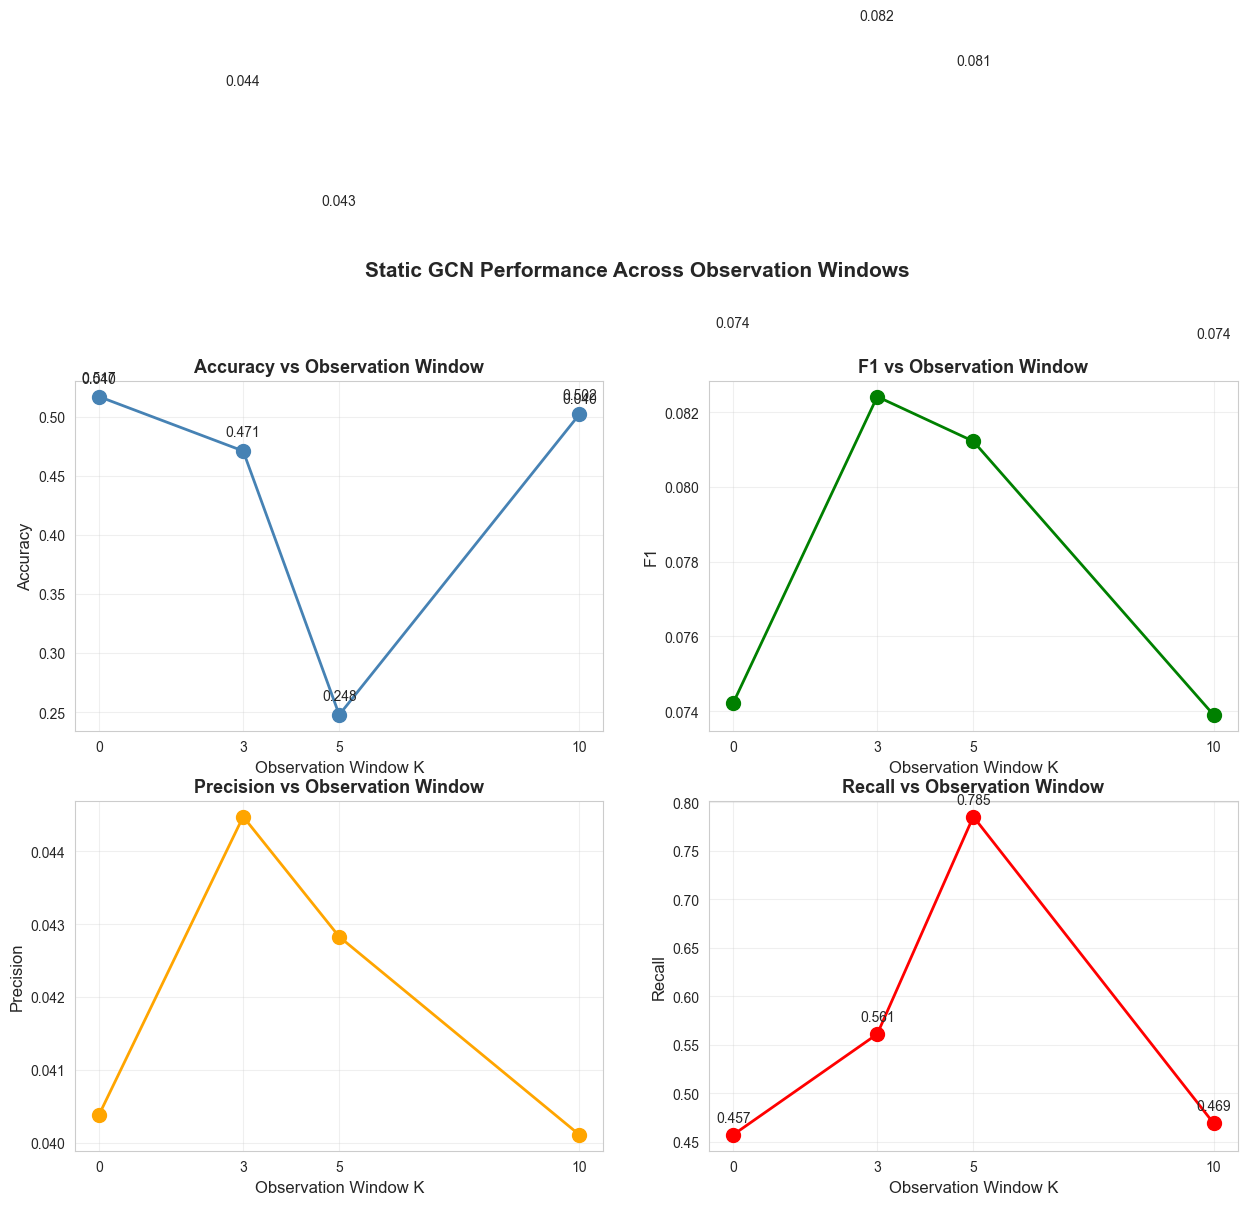

In [13]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
colors = ['steelblue', 'green', 'orange', 'red']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    values = comparison_df[metric].values
    ax.plot(CONFIG['observation_windows'], values, 
            marker='o', linewidth=2, markersize=10, color=color)
    
    # Add value labels
    for k, v in zip(CONFIG['observation_windows'], values):
        ax.text(k, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Observation Window K', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} vs Observation Window', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(CONFIG['observation_windows'])

plt.suptitle('Static GCN Performance Across Observation Windows', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Detailed Analysis

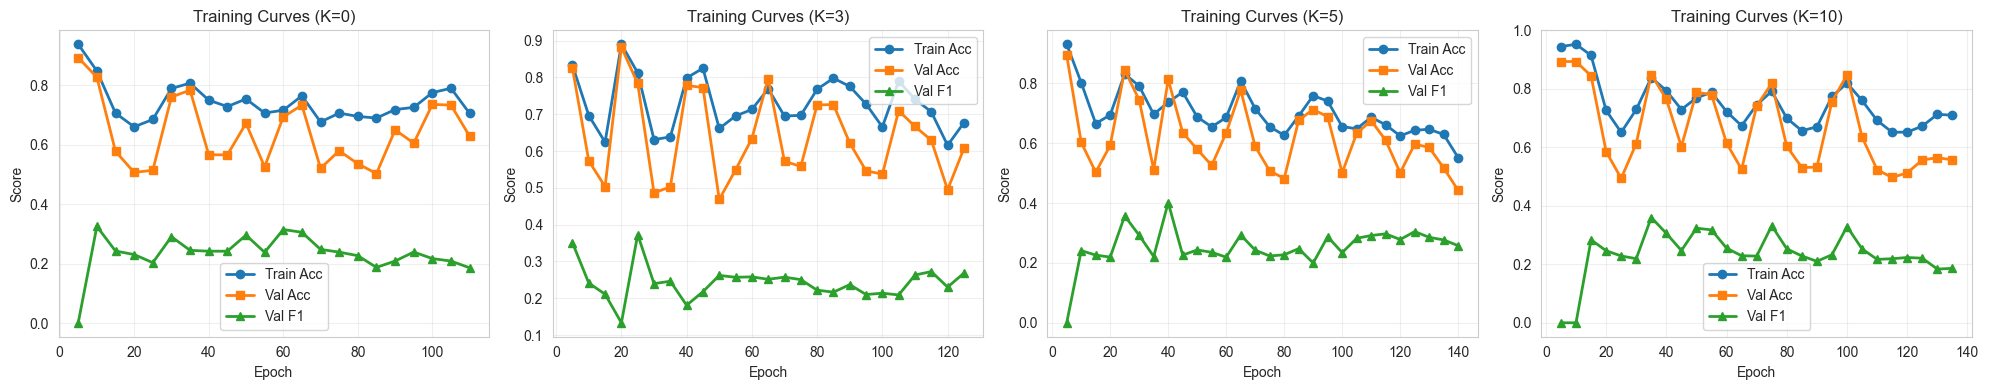

In [14]:
# Plot training curves for each K
fig, axes = plt.subplots(1, len(CONFIG['observation_windows']), 
                         figsize=(5*len(CONFIG['observation_windows']), 4))

if len(CONFIG['observation_windows']) == 1:
    axes = [axes]

for idx, K in enumerate(CONFIG['observation_windows']):
    ax = axes[idx]
    history = results[K]['history']
    
    epochs = list(range(5, 5*(len(history['train_loss'])+1), 5))
    
    ax.plot(epochs, history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    ax.plot(epochs, history['val_acc'], label='Val Acc', marker='s', linewidth=2)
    ax.plot(epochs, history['val_f1'], label='Val F1', marker='^', linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.set_title(f'Training Curves (K={K})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Preparing data for K=0...
  Building graph at t=45...
  Graph: 761396 nodes, 2552766 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Preparing data for K=3...
  Building graph at t=48...
  Graph: 811269 nodes, 2798924 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Preparing data for K=5...
  Building graph at t=50...
  Graph: 822942 nodes, 2868964 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808

Preparing data for K=10...
  Building graph at t=55...
  Graph: 822942 nodes, 2868964 edges
  Train nodes: 145858
  Val nodes:   32217
  Test nodes:  64808


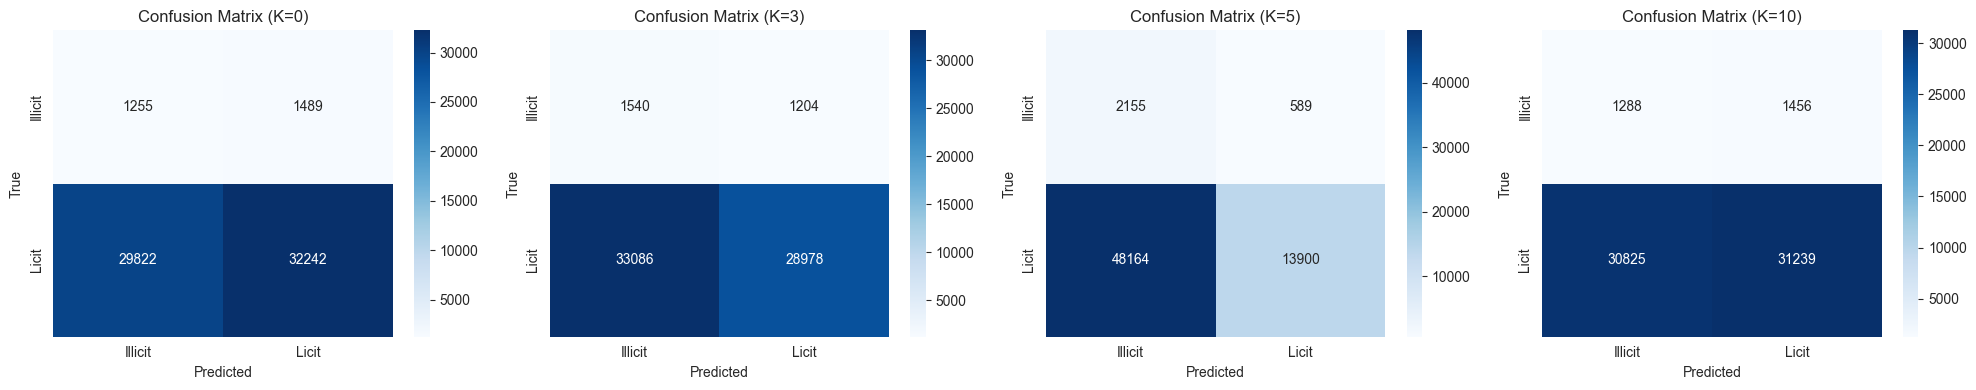

In [ ]:
# Confusion matrices for each K
fig, axes = plt.subplots(1, len(CONFIG['observation_windows']), 
                         figsize=(5*len(CONFIG['observation_windows']), 4))

if len(CONFIG['observation_windows']) == 1:
    axes = [axes]

for idx, K in enumerate(CONFIG['observation_windows']):
    ax = axes[idx]
    
    # Rebuild data to get predictions
    data = prepare_data_for_observation_window(
        K, builder, train_nodes, val_nodes, test_nodes, device
    )
    
    model = models[K]
    model.eval()
    
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits[data.test_mask].argmax(dim=1).cpu().numpy()
        true = data.y[data.test_mask].cpu().numpy()
    
    cm = confusion_matrix(true, pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Licit', 'Illicit'],
                yticklabels=['Licit', 'Illicit'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix (K={K})')

plt.tight_layout()
plt.show()

## 10. Key Insights

In [16]:
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Improvement from K=0 to K=max
k_min = CONFIG['observation_windows'][0]
k_max = CONFIG['observation_windows'][-1]

f1_improvement = results[k_max]['test']['f1'] - results[k_min]['test']['f1']
acc_improvement = results[k_max]['test']['accuracy'] - results[k_min]['test']['accuracy']

print(f"\n1. Performance Improvement (K={k_min} → K={k_max}):")
print(f"   Accuracy: {results[k_min]['test']['accuracy']:.4f} → {results[k_max]['test']['accuracy']:.4f} (+{acc_improvement:.4f})")
print(f"   F1 Score: {results[k_min]['test']['f1']:.4f} → {results[k_max]['test']['f1']:.4f} (+{f1_improvement:.4f})")

print(f"\n2. Best Observation Window:")
best_k = comparison_df.loc[comparison_df['F1'].idxmax(), 'K']
best_f1 = comparison_df['F1'].max()
print(f"   K={int(best_k)} achieves best F1 score of {best_f1:.4f}")

print(f"\n3. Cold Start Performance (K=0):")
print(f"   Can we classify nodes immediately at first appearance?")
print(f"   Accuracy: {results[0]['test']['accuracy']:.4f}")
print(f"   F1 Score: {results[0]['test']['f1']:.4f}")
if results[0]['test']['f1'] > 0.6:
    print(f"   → Reasonable performance even with K=0!")
else:
    print(f"   → Cold start is challenging, benefits from observation window")

print(f"\n4. Diminishing Returns:")
for i in range(len(CONFIG['observation_windows']) - 1):
    k1 = CONFIG['observation_windows'][i]
    k2 = CONFIG['observation_windows'][i+1]
    improvement = results[k2]['test']['f1'] - results[k1]['test']['f1']
    print(f"   K={k1}→{k2}: +{improvement:.4f} F1")

print("\n" + "="*70)
print("BASELINE ESTABLISHED")
print("="*70)
print("\nThis static GCN serves as baseline for temporal models.")
print("Next step: Train EvolveGCN and compare!")
print("\nExpected: Temporal GCN should outperform static GCN, especially")
print("          at smaller K values where temporal context is more valuable.")
print("="*70)


KEY INSIGHTS

1. Performance Improvement (K=0 → K=10):
   Accuracy: 0.5169 → 0.5019 (+-0.0150)
   F1 Score: 0.0742 → 0.0739 (+-0.0003)

2. Best Observation Window:
   K=3 achieves best F1 score of 0.0824

3. Cold Start Performance (K=0):
   Can we classify nodes immediately at first appearance?
   Accuracy: 0.5169
   F1 Score: 0.0742
   → Cold start is challenging, benefits from observation window

4. Diminishing Returns:
   K=0→3: +0.0082 F1
   K=3→5: +-0.0012 F1
   K=5→10: +-0.0073 F1

BASELINE ESTABLISHED

This static GCN serves as baseline for temporal models.
Next step: Train EvolveGCN and compare!

Expected: Temporal GCN should outperform static GCN, especially
          at smaller K values where temporal context is more valuable.


## 11. Save Results

In [17]:
# Save comparison table
comparison_df.to_csv('../results/static_gcn_results.csv', index=False)
print("✅ Results saved to ../results/static_gcn_results.csv")

# Save models
import os
os.makedirs('../models', exist_ok=True)

for K, model in models.items():
    torch.save(model.state_dict(), f'../models/static_gcn_k{K}.pt')
    print(f"✅ Model saved: ../models/static_gcn_k{K}.pt")

OSError: Cannot save file into a non-existent directory: '..\results'